In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
import shutil
import random
import matplotlib.pyplot as plt
import math

### Import jeu de train, test, validation

In [2]:
train_dir = 'C:\\Users\\Utilisateur\\Documents\\15_nonSuperviseClassification\\MedNIST Training Dataset'


# Définir la taille des images d'entrée et d'autres paramètres de prétraitement
img_size = (64,64)
batch_size = 47163

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Créez un générateur d'images avec prétraitement pour l'ensemble d'entraînement (train)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Utilisez les générateurs pour charger et prétraiter les ensembles de formation (train), de validation et de test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=47163,
    class_mode='sparse'
)


Found 47169 images belonging to 6 classes.


In [4]:
class_names = list(train_generator.class_indices.keys())
class_names

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

## Extraction des données d'entraînement

In [5]:
# Extraction des données d'entraînement
X, y = next(train_generator)

### Obtenir les troix jeux de donnees Train, vaidation et test

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary data (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary data into validation (50%) and test (50%)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the sizes of the resulting datasets
print("Size of training set:", len(X_train))
print("Size of validation set:", len(X_validation))
print("Size of test set:", len(X_test))


Size of training set: 37730
Size of validation set: 4716
Size of test set: 4717


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


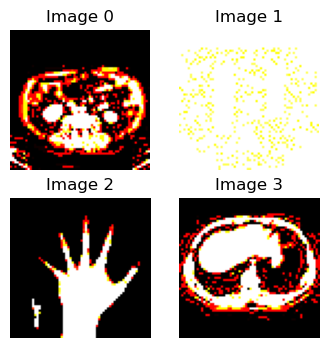

In [7]:
import matplotlib.pyplot as plt

# Sélectionnez les indices des images que vous souhaitez afficher
image_indices = [0, 1, 2, 3]  # Remplacez par les indices des images que vous souhaitez afficher

# Affichez les images dans une grille
plt.figure(figsize=(4, 4))  # Ajustez la taille de la figure
for i, index in enumerate(image_indices):
    plt.subplot(2, 2, i + 1)  # Créez une sous-figure dans une grille 2x2
    plt.imshow(X_train[index])
    plt.axis('off')  # Pour masquer les axes
    plt.title(f"Image {index}")  # Titre de l'image

plt.show()


## Charger le modèle ResNet50 pré-entraîné et extraire les caractéristiques des images

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Chargement du modèle ResNet-50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3)) 

#  extraire des caractéristiques
train_features = base_model.predict(X_train)
validation_features = base_model.predict(X_validation)
test_features = base_model.predict(X_test)


148/148 [==============================] - 48s 326ms/step


## Aplatir les caractéristiques extraites

In [9]:
import numpy as np

X_train_features_flat = train_features.reshape(train_features.shape[0], -1)
X_validation_features_flat = validation_features.reshape(validation_features.shape[0], -1)
X_test_features_flat = test_features.reshape(test_features.shape[0], -1)


In [10]:
X_train_features_flat.shape
y_train.shape

(37730,)

## Creer un SVM pour entrainer le modele

In [11]:
from sklearn import svm

# Créez un modèle SVM
svm_model = svm.SVC(kernel='linear', C=1.0)

# Entraînez le modèle SVM avec les caractéristiques extraites
svm_model.fit(X_train_features_flat, y_train)


SVC(kernel='linear')

## enregistrer le modele

In [12]:
import joblib

# Enregistrez le modèle SVM
joblib.dump(svm_model, 'modele_svm.pkl')

['modele_svm.pkl']

### evaluer la performance du modele

In [13]:
pip install scikit-plot


Note: you may need to restart the kernel to use updated packages.


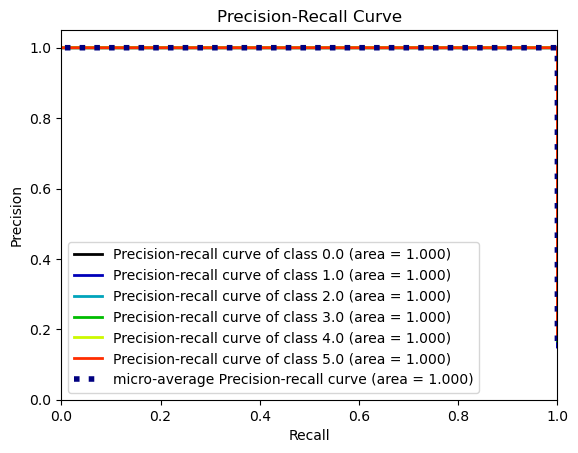

In [14]:
from sklearn.metrics import precision_recall_curve
import scikitplot as skplt
# Calculer les scores de décision sur l'ensemble de validation

decision_scores = svm_model.decision_function(X_validation_features_flat)


# Tracer la courbe de précision et de rappel pour la classification multiclasse
skplt.metrics.plot_precision_recall(y_validation, decision_scores)

plt.show()

### Predictions

In [15]:
# Faites des prédictions sur l'ensemble de train
y_pred_train = svm_model.predict(X_train_features_flat)

# Faites des prédictions sur l'ensemble de validation
y_pred_validation = svm_model.predict(X_validation_features_flat)

# Faites des prédictions sur l'ensemble de test
y_pred_test = svm_model.predict(X_test_features_flat)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(classification_report(y_validation, y_pred_validation))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       763
         1.0       1.00      1.00      1.00       706
         2.0       1.00      1.00      1.00       800
         3.0       1.00      1.00      1.00       789
         4.0       1.00      1.00      1.00       823
         5.0       1.00      1.00      1.00       835

    accuracy                           1.00      4716
   macro avg       1.00      1.00      1.00      4716
weighted avg       1.00      1.00      1.00      4716



In [17]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       784
         1.0       1.00      1.00      1.00       709
         2.0       1.00      1.00      1.00       839
         3.0       1.00      1.00      1.00       783
         4.0       1.00      1.00      1.00       815
         5.0       1.00      1.00      1.00       787

    accuracy                           1.00      4717
   macro avg       1.00      1.00      1.00      4717
weighted avg       1.00      1.00      1.00      4717



In [18]:
print(classification_report(y_train, y_pred_train))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6451
         1.0       1.00      1.00      1.00      5748
         2.0       1.00      1.00      1.00      6359
         3.0       1.00      1.00      1.00      6427
         4.0       1.00      1.00      1.00      6362
         5.0       1.00      1.00      1.00      6383

    accuracy                           1.00     37730
   macro avg       1.00      1.00      1.00     37730
weighted avg       1.00      1.00      1.00     37730



### Matrice de confusion

In [20]:
# Matrice de confusion jeu d'apprentissage
print("Matrice de confusion jeu d'apprentissage ")
print(confusion_matrix(y_train, y_pred_train))

# Matrice de confusion jeu de test
print("Matrice de confusion jeu de test")
print(confusion_matrix(y_test, y_pred_test))

# Matrice de confusion jeu de test
print("Matrice de confusion jeu de validation")
print(confusion_matrix(y_validation, y_pred_validation))

Matrice de confusion jeu d'apprentissage 
[[6451    0    0    0    0    0]
 [   0 5748    0    0    0    0]
 [   0    0 6359    0    0    0]
 [   0    0    0 6427    0    0]
 [   0    0    0    0 6362    0]
 [   0    0    0    0    0 6383]]
Matrice de confusion jeu de test
[[784   0   0   0   0   0]
 [  0 709   0   0   0   0]
 [  0   0 839   0   0   0]
 [  0   0   0 783   0   0]
 [  0   0   0   0 815   0]
 [  0   0   0   0   0 787]]
Matrice de confusion jeu de validation
[[763   0   0   0   0   0]
 [  0 706   0   0   0   0]
 [  0   0 800   0   0   0]
 [  0   0   0 789   0   0]
 [  0   0   0   0 823   0]
 [  0   0   0   0   0 835]]


In [21]:
# Créez la matrice de confusion
confusion = confusion_matrix(y_test, y_pred_test)
print("Matrice de confusion :")
print(confusion)

Matrice de confusion :
[[784   0   0   0   0   0]
 [  0 709   0   0   0   0]
 [  0   0 839   0   0   0]
 [  0   0   0 783   0   0]
 [  0   0   0   0 815   0]
 [  0   0   0   0   0 787]]


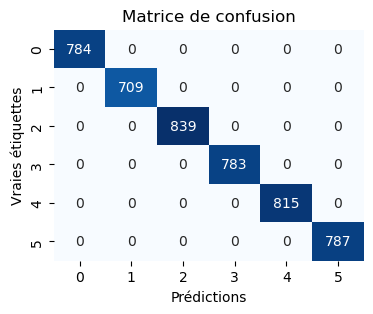

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# Créez une heatmap à partir de la matrice de confusion
plt.figure(figsize=(4, 3))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()